In [11]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import SubsetRandomSampler
import zipfile
from PIL import Image
from sklearn.metrics import classification_report


In [2]:
# Check if CUDA is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Unzip the dataset (if it's in /content)
zip_path = "/content/Dataset.zip"  # Replace with your ZIP file name
extract_path = "/content/Dataset"  # Replace with your desired extraction path

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Dataset extracted to {extract_path}")
else:
    print(f"Dataset already extracted at {extract_path}")


Using device: cuda
Dataset extracted to /content/Dataset


In [4]:
# Setting the dataset root
data_dir = extract_path

# Printing classes
classes = os.listdir(data_dir)
print(f"Classes in the dataset are: {len(classes)}")
print(classes)



Classes in the dataset are: 30
['Tabernaemontana Divaricata (Crape Jasmine)', 'Amaranthus Viridis (Arive-Dantu)', 'Mentha (Mint)', 'Nyctanthes Arbor-tristis (Parijata)', 'Piper Betle (Betel)', 'Mangifera Indica (Mango)', 'Artocarpus Heterophyllus (Jackfruit)', 'Nerium Oleander (Oleander)', 'Citrus Limon (Lemon)', 'Basella Alba (Basale)', 'Pongamia Pinnata (Indian Beech)', 'Muntingia Calabura (Jamaica Cherry-Gasagase)', 'Santalum Album (Sandalwood)', 'Carissa Carandas (Karanda)', 'Jasminum (Jasmine)', 'Ocimum Tenuiflorum (Tulsi)', 'Psidium Guajava (Guava)', 'Syzygium Jambos (Rose Apple)', 'Moringa Oleifera (Drumstick)', 'Plectranthus Amboinicus (Mexican Mint)', 'Azadirachta Indica (Neem)', 'Punica Granatum (Pomegranate)', 'Hibiscus Rosa-sinensis', 'Brassica Juncea (Indian Mustard)', 'Ficus Auriculata (Roxburgh fig)', 'Murraya Koenigii (Curry)', 'Trigonella Foenum-graecum (Fenugreek)', 'Ficus Religiosa (Peepal Tree)', 'Syzygium Cumini (Jamun)', 'Alpinia Galanga (Rasna)']


In [5]:
### Data Preprocessing ###

# Define transforms with data augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

# Define transforms for validation and testing
val_test_transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
])

# Load the dataset
dataset = ImageFolder(data_dir, transform=train_transform)

# Stratified splitting
def stratified_split(dataset, test_size=0.2, val_size=0.1, random_state=42):
    targets = dataset.targets
    train_idx, test_idx = train_test_split(
        np.arange(len(targets)),
        test_size=test_size,
        stratify=targets,
        random_state=random_state
    )
    train_idx, val_idx = train_test_split(
        train_idx,
        test_size=val_size,
        stratify=[targets[i] for i in train_idx],
        random_state=random_state
    )
    return train_idx, val_idx, test_idx

train_idx, val_idx, test_idx = stratified_split(dataset)

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
test_sampler = SubsetRandomSampler(test_idx)

# Create DataLoaders
batch_size = 32
train_dl = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
val_dl = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
test_dl = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)


In [6]:
### Model Definition ###

class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [8]:
# Initialize the model
num_classes = len(classes)
model = VGG16(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.005)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Early stopping
early_stopping_patience = 3
best_val_loss = float('inf')
patience_counter = 0

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_dl:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_dl)
    val_accuracy = 100 * correct / total

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {running_loss/len(train_dl):.4f}, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Validation Accuracy: {val_accuracy:.2f}%')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break



Epoch [1/30], Training Loss: 3.3650, Validation Loss: 3.3461, Validation Accuracy: 6.80%
Epoch [2/30], Training Loss: 2.9189, Validation Loss: 2.4752, Validation Accuracy: 29.93%
Epoch [3/30], Training Loss: 2.2696, Validation Loss: 1.8444, Validation Accuracy: 49.66%
Epoch [4/30], Training Loss: 1.6632, Validation Loss: 1.5091, Validation Accuracy: 53.74%
Epoch [5/30], Training Loss: 1.3734, Validation Loss: 1.5571, Validation Accuracy: 51.02%
Epoch [6/30], Training Loss: 1.0508, Validation Loss: 0.9205, Validation Accuracy: 71.43%
Epoch [7/30], Training Loss: 0.9353, Validation Loss: 0.8827, Validation Accuracy: 76.19%
Epoch [8/30], Training Loss: 0.8808, Validation Loss: 0.7846, Validation Accuracy: 75.51%
Epoch [9/30], Training Loss: 0.8462, Validation Loss: 0.7692, Validation Accuracy: 77.55%
Epoch [10/30], Training Loss: 0.8024, Validation Loss: 0.7431, Validation Accuracy: 78.23%
Epoch [11/30], Training Loss: 0.7638, Validation Loss: 0.7663, Validation Accuracy: 80.27%
Epoch [12

In [10]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Testing
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Classification report
print(classification_report(y_true, y_pred, target_names=classes))


<ipython-input-10-14608945a929>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


                                              precision    recall  f1-score   support

  Tabernaemontana Divaricata (Crape Jasmine)       0.90      0.90      0.90        10
            Amaranthus Viridis (Arive-Dantu)       0.69      0.96      0.80        25
                               Mentha (Mint)       0.77      0.91      0.83        11
         Nyctanthes Arbor-tristis (Parijata)       0.90      0.75      0.82        12
                         Piper Betle (Betel)       0.86      0.90      0.88        21
                    Mangifera Indica (Mango)       1.00      0.71      0.83         7
        Artocarpus Heterophyllus (Jackfruit)       0.88      1.00      0.94        15
                  Nerium Oleander (Oleander)       0.80      0.36      0.50        11
                        Citrus Limon (Lemon)       0.57      0.40      0.47        10
                       Basella Alba (Basale)       1.00      1.00      1.00        13
             Pongamia Pinnata (Indian Beech)       0.

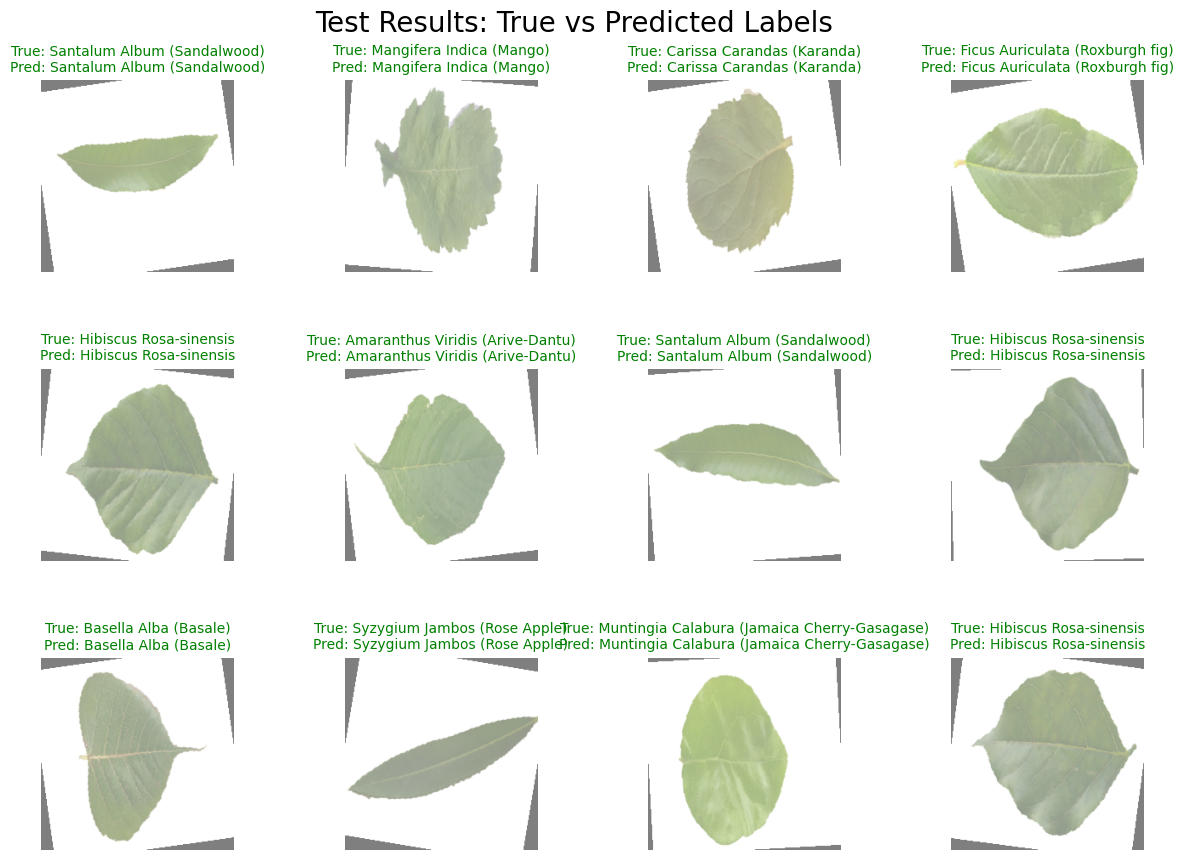

In [26]:
### ANALYZE TESTING IMAGES PERFORMANCE ###

# Visualize test results with improved layout and image display
def visualize_test_results(test_dl, model, classes, device, num_images=12):
    model.eval()
    dataiter = iter(test_dl)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    # Get predictions
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # Move images and labels to CPU for visualization
    images = images.cpu()
    labels = labels.cpu()
    predicted = predicted.cpu()

    # Unnormalize images for correct display
    images = images / 2 + 0.5

    # Adjust number of images to the available batch size
    num_images = min(num_images, len(images))

    # Create a grid of images
    rows = (num_images + 3) // 4  # Calculate rows needed based on 4 images per row
    fig, axes = plt.subplots(rows, 4, figsize=(15, 10))
    fig.subplots_adjust(hspace=0.5)
    axes = axes.flatten()

    for i in range(num_images):
        img = np.transpose(images[i].numpy(), (1, 2, 0))
        axes[i].imshow(img)
        axes[i].axis('off')

        true_label = classes[labels[i]]
        pred_label = classes[predicted[i]]
        color = "green" if true_label == pred_label else "red"

        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=10, color=color)

    # Hide unused subplots if any
    for ax in axes[num_images:]:
        ax.axis('off')

    # Set the title above the grid
    plt.suptitle("Test Results: True vs Predicted Labels", fontsize=20, y=0.95)
    plt.show()

# Call the function to visualize test results
visualize_test_results(test_dl, model, classes, device, num_images=12)


In [25]:
### CODE TO FREE MEMORY ###

import gc
torch.cuda.empty_cache()  # Clear the cache
gc.collect()  # Force garbage collection
del outputs